In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

import FEAutils as hlp

In [2]:
from IPython.display import JSON

In [3]:
powerdict_fp = 'https://raw.githubusercontent.com/OSUKED/Power-Station-Dictionary/shiro/data/dictionary/ids.csv'

df_powerdict = pd.read_csv(powerdict_fp)

df_powerdict.head(3)

,dictionary_id,gppd_idnr,esail_id,name,sett_bmu_id,ngc_bmu_id,4c_offshore_id,windpowernet_id,wikidata_id,wikipedia_id,power_technology_id,eutl_id,eic_id,cfd_id
0,10000,NaN,MARK,Rothes Bio-Plant CHP,"E_MARK-1, E_MARK-2","MARK-1, MARK-2",NaN,NaN,NaN,NaN,NaN,NaN,48W000000MARK-1D,NaN
1,10001,"GBR1000377, GBR1000369",DIDC,Didcot,"T_DIDC1, T_DIDC2, T_DIDC4, T_DIDC3, T_DIDC1G, ...","DIDC1, DIDC2, DIDC4, DIDC3, DIDC1G, DIDC2G, DI...",NaN,NaN,NaN,NaN,NaN,97165,"48W00000DIDC01G1, 48W00000DIDC02GZ, 48W00000DI...",NaN
2,10002,"GBR1000374, GBR1000375",ABTH,Aberthaw B,"T_ABTH7, T_ABTH8, T_ABTH9, T_ABTH7G, T_ABTH8G,...","ABTH7, ABTH8, ABTH9, ABTH7G, ABTH8G, ABTH9G",NaN,NaN,NaN,NaN,NaN,97175,"48W0000000ABTH7Y, 48W0000000ABTH8W, 48W0000000...",NaN


In [34]:
#exports
def load_ei_year_focus(
    year: int
):
    df_ei = pd.read_csv(f'https://raw.githubusercontent.com/AyrtonB/Electric-Insights/master/data/electric_insights_{year}.csv')
    
    df_ei['local_datetime'] = pd.to_datetime(df_ei['local_datetime'], utc=True)
    df_ei = df_ei.set_index('local_datetime')
    df_ei_focus = df_ei[['demand', 'day_ahead_price']]
    
    return df_ei_focus

In [37]:
year = 2015

df_ei_focus = load_ei_year_focus(year)

df_ei_focus.head()

,demand,day_ahead_price
local_datetime,,
2015-01-01 00:00:00+00:00,30.662,37.31
2015-01-01 00:30:00+00:00,31.260,38.20
2015-01-01 01:00:00+00:00,30.949,34.42
2015-01-01 01:30:00+00:00,29.860,30.78
2015-01-01 02:00:00+00:00,28.714,31.00


In [4]:
wind_farms_fp = '../datasets/wind-farms/wind-farms.csv'

df_wind_farms = pd.read_csv(wind_farms_fp)

df_wind_farms.head()

,dictionary_id,plant_type,hub_height
0,10156,offshore,75.0
1,10165,offshore,62.0
2,10169,offshore,88.0
3,10170,offshore,105.0
4,10185,offshore,110.0


In [5]:
capture_price_fp = '../datasets/capture-prices/capture-prices.csv'

df_capture_prices = pd.read_csv(capture_price_fp)

df_capture_prices.head()

,ngc_bmu_id,year,capture_price
0,ABRBO-1,2019,39.429610
1,ABRBO-1,2020,32.759415
2,ABRTW-1,2019,39.711074
3,ABRTW-1,2020,32.610071
4,ABTH7,2016,42.271283


In [6]:
fuel_types_fp = '../datasets/bmu-fuel-types/BMUFuelType 2021-08-09.csv'

df_fuel_types = pd.read_csv(fuel_types_fp)

df_fuel_types.head()

,NGC_BMU_ID,SETT_BMU_ID,FUEL TYPE,EFF_FROM,EFF_TO,Comments,EELPS?
0,ABRBO-1,T_ABRBO-1,WIND,29/08/2017 00:00,NaN,NaN,NaN
1,ABRTW-1,E_ABRTW-1,WIND,05/09/2016 00:00,NaN,NaN,NaN
2,ACHLW-1,C__PSMAR001,WIND,05/09/2018 00:00,NaN,C__PSMAR001,NaN
3,ACHRW-1,T_ACHRW-1,WIND,01/10/2015 00:00,NaN,T_ACHRW-1,NaN
4,ACHYW-1,NaN,WIND,07/06/2010 00:00,NaN,NaN,EELPS


In [7]:
df_fuel_types['FUEL TYPE'].value_counts()

WIND       192
CCGT        63
NPSHYD      36
OCGT        22
BIOMASS     18
PS          16
NUCLEAR     16
COAL        10
OTHER        4
Wind         1
Name: FUEL TYPE, dtype: int64

In [8]:
wind_bmu_ids = (
     df_fuel_types
     .set_index('NGC_BMU_ID')
     .query('(`FUEL TYPE`=="WIND")|(`FUEL TYPE`=="Wind")')
     .index
)

wind_bmu_ids

Index(['ABRBO-1', 'ABRTW-1', 'ACHLW-1', 'ACHRW-1', 'ACHYW-1', 'AFTOW-1',
       'AIRSW-1', 'AKGLW-1', 'AKGLW-2', 'AKGLW-3',
       ...
       'WHIHW-1', 'WHILW-1', 'WHILW-2', 'WISTW-2', 'WLNYO-2', 'WLNYO-3',
       'WLNYO-4', 'WLNYW-1', 'WTGRW-1', 'WTMSO-1'],
      dtype='object', name='NGC_BMU_ID', length=193)

Text(0, 0.5, 'Count')

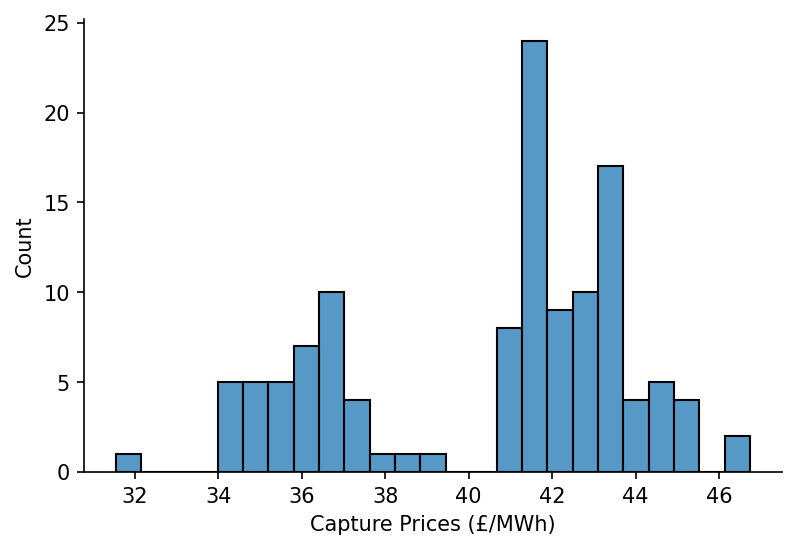

In [9]:
df_wind_capture_prices = df_capture_prices.loc[df_capture_prices['ngc_bmu_id'].isin(wind_bmu_ids)]
s_avg_wind_capture_prices = df_wind_capture_prices.groupby('ngc_bmu_id')['capture_price'].mean()

# Plotting
fig, ax = plt.subplots(dpi=150)

sns.histplot(s_avg_wind_capture_prices, bins=25, ax=ax)

hlp.hide_spines(ax)
ax.set_xlabel('Capture Prices (£/MWh)')
ax.set_ylabel('Count')

In [10]:
#exports
def construct_ngc_bmu_to_dictionary_ids(df_powerdict):
    ngc_bmu_to_dictionary_ids = {}

    for dictionary_id, ngc_bmu_ids in df_powerdict.set_index('dictionary_id')['ngc_bmu_id'].dropna().items():
        for ngc_bmu_id in ngc_bmu_ids.split(', '):
            ngc_bmu_to_dictionary_ids[ngc_bmu_id] = dictionary_id
            
    return ngc_bmu_to_dictionary_ids

In [11]:
ngc_bmu_to_dictionary_ids = construct_ngc_bmu_to_dictionary_ids(df_powerdict)
dictionary_id_to_wf_type = df_wind_farms.set_index('dictionary_id')['plant_type'].to_dict()
ngc_bmu_id_to_wf_type = {k: dictionary_id_to_wf_type[v] for k, v in ngc_bmu_to_dictionary_ids.items() if v in dictionary_id_to_wf_type.keys()}

s_wf_types = pd.Series(ngc_bmu_id_to_wf_type)

s_wf_types.head()

ACHRW-1    onshore
AKGLW-2    onshore
AKGLW-3    onshore
AIRSW-1    onshore
ASHWW-1    onshore
dtype: object

In [12]:
## need to do a weighted average by capacity

In [13]:
#exports
def extract_year_wind_type_capture_prices_s(
    df_wind_capture_prices: pd.DataFrame,
    s_wf_types: pd.Series,
    year: int=2020,
    wf_types: list=['offshore']
):
    s_year_wind_capture_prices = df_wind_capture_prices.query(f'`year`==@year').set_index('ngc_bmu_id')['capture_price']
    wf_type_sett_bmu_ids = s_wf_types[s_wf_types.isin(wf_types)].index.intersection(s_year_wind_capture_prices.index)
    s_year_wind_type_capture_prices = s_year_wind_capture_prices.loc[wf_type_sett_bmu_ids]

    return s_year_wind_type_capture_prices

In [14]:
year = 2020,
wf_types = ['offshore']
    
s_year_wind_type_capture_prices = extract_year_wind_type_capture_prices_s(df_wind_capture_prices, s_wf_types, year, wf_types)

s_year_wind_type_capture_prices.sort_values(ascending=False).head()

GAOFO-4    41.558583
GAOFO-3    41.427562
GAOFO-2    41.244893
GAOFO-1    41.101195
EAAO-2     33.334225
Name: capture_price, dtype: float64

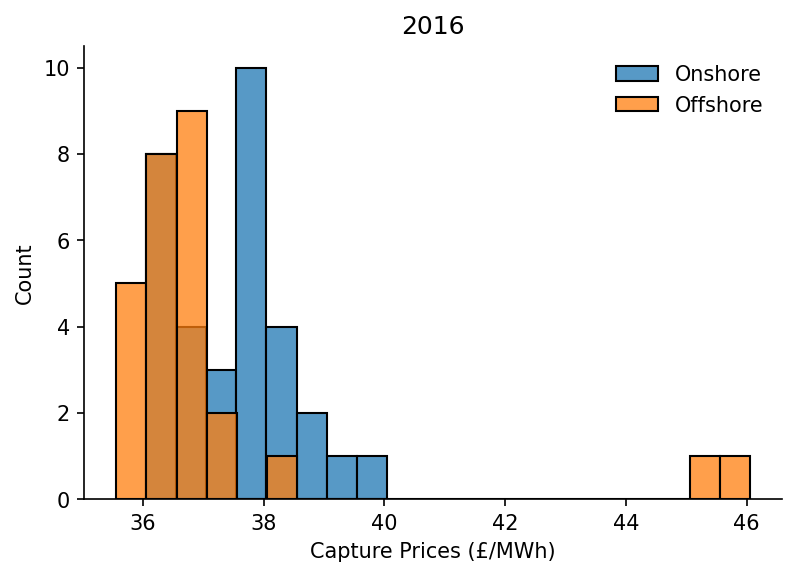

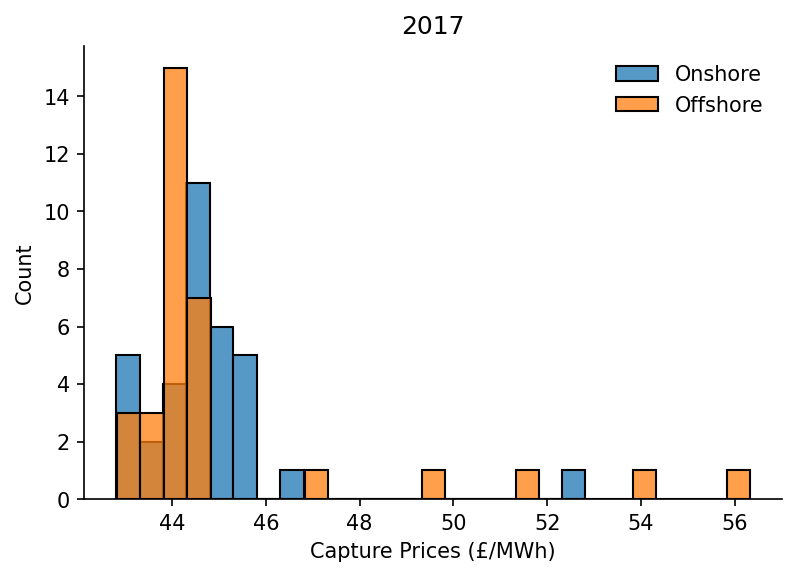

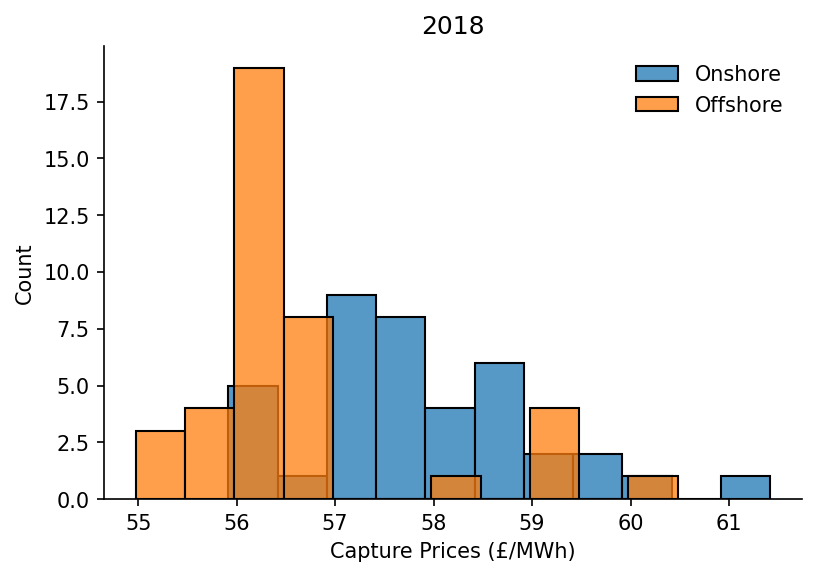

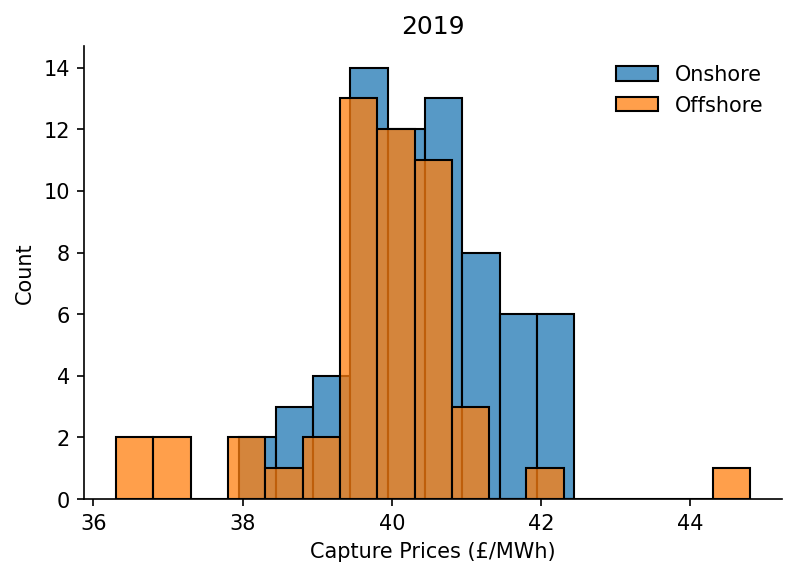

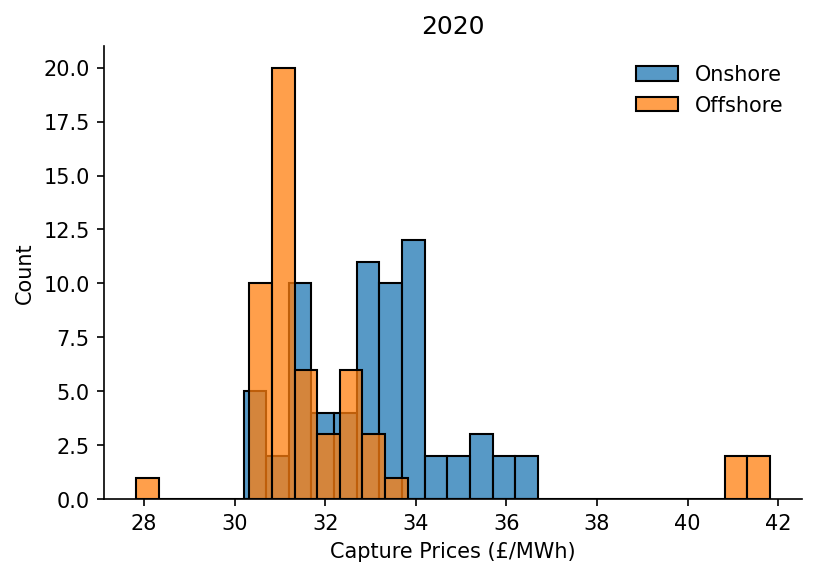

In [15]:
wf_types = ['onshore', 'offshore']
avg_capture_prices = []

for year in sorted(df_wind_capture_prices['year'].unique()):
    fig, ax = plt.subplots(dpi=150)

    for i, wf_type in enumerate(wf_types):
        s_year_wind_type_capture_prices = s_year_wind_type_capture_prices = extract_year_wind_type_capture_prices_s(df_wind_capture_prices, s_wf_types, year, [wf_type])
        
        avg_capture_prices += [(year, wf_type, s_year_wind_type_capture_prices.mean())]
        sns.histplot(s_year_wind_type_capture_prices, binwidth=0.5, ax=ax, color=f'C{i}', label=wf_type.capitalize())

    ax.set_title(year)
    hlp.hide_spines(ax)
    ax.set_xlabel('Capture Prices (£/MWh)')
    ax.set_ylabel('Count')
    ax.legend(frameon=False)

In [42]:
%%time

years = range(2016, 2021)
s_annual_price_avgs = pd.Series(index=years, dtype=float)

for year in years:
    df_ei_focus = load_ei_year_focus(year).dropna()
    s_annual_price_avgs.loc[year] = np.average(df_ei_focus['day_ahead_price'], weights=df_ei_focus['demand'])
    
s_annual_price_avgs

Wall time: 3.86 s


2016    40.550730
2017    46.273617
2018    57.494518
2019    44.188151
2020    35.087677
dtype: float64

In [56]:
# should do a jittered plot showing the annual averages for every wind farm

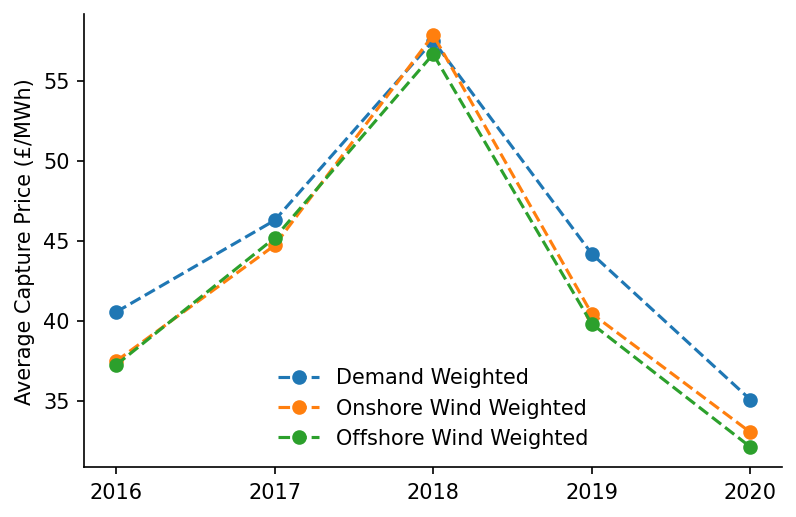

In [48]:
df_annual_cp_by_type = (
    pd.DataFrame(avg_capture_prices, columns=['year', 'wf_type', 'capture_price'])
    .astype({
        'year': int, 
        'wf_type': str, 
        'capture_price': float
    })
)

# Plotting
fig, ax = plt.subplots(dpi=150)

s_annual_price_avgs.plot(linestyle='--', marker='o', ax=ax, label='Demand Weighted')

for wf_type in wf_types:
    (df_annual_cp_by_type
     .query('wf_type==@wf_type')
     .set_index('year')
     ['capture_price']
     .plot(linestyle='--', marker='o', ax=ax, label=f'{wf_type.capitalize()} Wind Weighted'))

ax.set_xlabel('')
ax.set_ylabel('Average Capture Price (£/MWh)')
hlp.hide_spines(ax)
ax.legend(frameon=False)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

In [59]:
s_wf_type_avg_can = 1 - df_annual_cp_by_type.groupby('wf_type')['capture_price'].mean()/s_annual_price_avgs.mean()
s_wf_type_avg_can.name = 'average_cannibalisation_pct'

s_wf_type_avg_can

wf_type
offshore    0.056208
onshore     0.044947
Name: average_cannibalisation_pct, dtype: float64

Text(0.5, 0, 'Normalised Capture Price')

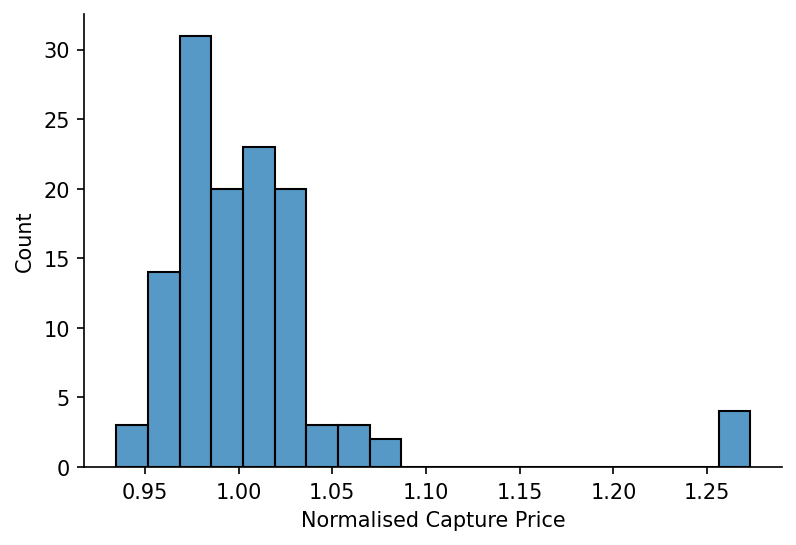

In [18]:
df_normed_capture_prices = pd.DataFrame()

for year in sorted(df_wind_capture_prices['year'].unique()):
    s_year_wind_type_capture_prices = extract_year_wind_type_capture_prices_s(df_wind_capture_prices, s_wf_types, year, wf_types)

    s_normed_capture_prices = s_year_wind_type_capture_prices.divide(s_year_wind_type_capture_prices.mean())
    s_normed_capture_prices.name = 'normalised_capture_price'
    s_normed_capture_prices.index = pd.MultiIndex.from_arrays([s_normed_capture_prices.index, s_normed_capture_prices.shape[0]*[year]], names=['ngc_bmu_id', 'year'])

    df_normed_capture_prices = df_normed_capture_prices.append(s_normed_capture_prices.reset_index())

s_avg_normed_capture_prices = df_normed_capture_prices.groupby('ngc_bmu_id')['normalised_capture_price'].mean()

# Plotting
fig, ax = plt.subplots(dpi=150)

sns.histplot(s_avg_normed_capture_prices, ax=ax)

hlp.hide_spines(ax)
ax.set_xlabel('Normalised Capture Price')

In [19]:
s_avg_normed_capture_prices.sort_values(ascending=False).head(25)

ngc_bmu_id
GAOFO-4    1.272966
GAOFO-3    1.268953
GAOFO-2    1.263357
GAOFO-1    1.258956
STRNW-1    1.079493
BHLAW-1    1.075603
DUNGW-1    1.065390
GORDW-1    1.059207
RMPNO-1    1.057743
STLGW-2    1.044172
CGTHW-1    1.044070
STLGW-3    1.038340
LCLTW-1    1.032003
GNFSW-2    1.031740
BETHW-1    1.031651
EDINW-1    1.030029
GNFSW-1    1.029563
WLNYO-4    1.027814
ARCHW-1    1.027610
STLGW-1    1.027259
FAARW-2    1.025738
CRMLW-1    1.025542
WLNYO-3    1.025378
HYWDW-1    1.024565
RMPNO-2    1.024302
Name: normalised_capture_price, dtype: float64